In [249]:
import os
import re
import itertools
import datetime
import math
from collections import Counter

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import gensim
from gensim.utils import simple_preprocess
from gensim import corpora, models
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import nltk
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

Playing with the written statements from the Expressive Writing study. 

sources:
https://www.kaggle.com/dskswu/topic-modeling-bert-lda - topic modeling bert+lda

Specify path to input directory and read in files.

In [14]:
home = 1
if home:
    infiledir = r"C:\Users\Luzia T\UCL\WorkingFromHome\Possible_online_studies\NLP_expressive_writing\analysis\Processed_2"
    writing_dir = r"C:\Users\Luzia T\UCL\WorkingFromHome\Possible_online_studies\NLP_expressive_writing\analysis\writing_data\statements"
else:
    infiledir = r"P:\EW_analysis\analysis\Processed_2"
    writing_dir = r"P:\EW_analysis\analysis\writing\writing_data"



In [15]:
for dirname, _, filenames in os.walk(writing_dir):
    for filename in filenames:
        print(os.path.join(dirname, filename))


ew_files = [f for f in filenames if 'T1' in f]
ewre_files = [f for f in filenames if 'T2' in f]
ctr_files = [f for f in filenames if 'T3' in f]


C:\Users\Luzia T\UCL\WorkingFromHome\Possible_online_studies\NLP_expressive_writing\analysis\writing_data\statements\Writing_T1_Day1.csv
C:\Users\Luzia T\UCL\WorkingFromHome\Possible_online_studies\NLP_expressive_writing\analysis\writing_data\statements\Writing_T1_Day2.csv
C:\Users\Luzia T\UCL\WorkingFromHome\Possible_online_studies\NLP_expressive_writing\analysis\writing_data\statements\Writing_T1_Day3.csv
C:\Users\Luzia T\UCL\WorkingFromHome\Possible_online_studies\NLP_expressive_writing\analysis\writing_data\statements\Writing_T1_Day4.csv
C:\Users\Luzia T\UCL\WorkingFromHome\Possible_online_studies\NLP_expressive_writing\analysis\writing_data\statements\Writing_T2_Day1.csv
C:\Users\Luzia T\UCL\WorkingFromHome\Possible_online_studies\NLP_expressive_writing\analysis\writing_data\statements\Writing_T2_Day2.csv
C:\Users\Luzia T\UCL\WorkingFromHome\Possible_online_studies\NLP_expressive_writing\analysis\writing_data\statements\Writing_T2_Day3.csv
C:\Users\Luzia T\UCL\WorkingFromHome\Poss

In [124]:
def get_diaries(directory,filenames,group_name):
    """ 
    read in files from each group/day of writing
    in: path to input directory, list of filenames, condition name (EW, EWRE or CTR)
    out: list of lists of data from all days of writing for the specified group.
    """
    all_files = []
    for i,name in enumerate(filenames):
        diary_df = pd.read_csv(os.path.join(directory,name),skiprows = [0,2])
        # retain only records of people who finished the survey
        diary_df = diary_df.loc[diary_df.Progress==100,:]
        # what day of writing were they on
        diary_df['day'] = i+1
        diary_df['Group'] = group_name
        writing_col = diary_df.filter(like = 'Please use the box below').columns[0]
        diary_df = diary_df.rename(columns = {writing_col: 'writing'})
        id_col = diary_df.filter(like = 'participant ID').columns[0]
        diary_df = diary_df.rename(columns = {id_col: 'id'})
        all_files.append(diary_df)
    return all_files

def read_files(infiles):
    """
    convert list of lists to dataframe.
    in: list of lists (output from get_diaries) 
    """
    all_df = pd.concat([pd.DataFrame(infiles[0]), pd.DataFrame(infiles[1]),pd.DataFrame(infiles[2]),pd.DataFrame(infiles[3])])
    return all_df

In [125]:
all_ew = get_diaries(writing_dir, ew_files,'EW')
ew_df = read_files(all_ew)
all_ewre = get_diaries(writing_dir, ewre_files,'EWRE')
ewre_df = read_files(all_ewre)
all_ctr = get_diaries(writing_dir, ctr_files,'CTR')
ctr_df = read_files(all_ctr)
writing_df = pd.concat([ew_df,ewre_df,ctr_df])


# save if needed
save = 0
if save:
    writing_df.to_csv(os.path.join(writing_dir, 'writing_df.csv'))


In [ ]:
all_dat_df = pd.read_csv(os.path.join(infiledir, 'all_dat_df.csv'))

Let's check whether we have roughly the same number of statements in each condition. We sort of know this is true, but nice to have a quick visual confirmation.

[Text(0, 0.5, 'Number of statements'), Text(0.5, 1.0, 'Statements per Group')]

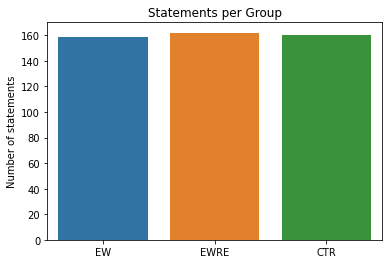

In [49]:
sns.barplot(x = writing_df.Group.unique(), y = [len(ew_df),len(ewre_df),len(ctr_df)]).set(ylabel = 'Number of statements', title = 'Statements per Group')

We'll now have a look at the top 50 words in each group before doing any preprocessing on the text.

Text(0.5, 1.0, 'CTR')

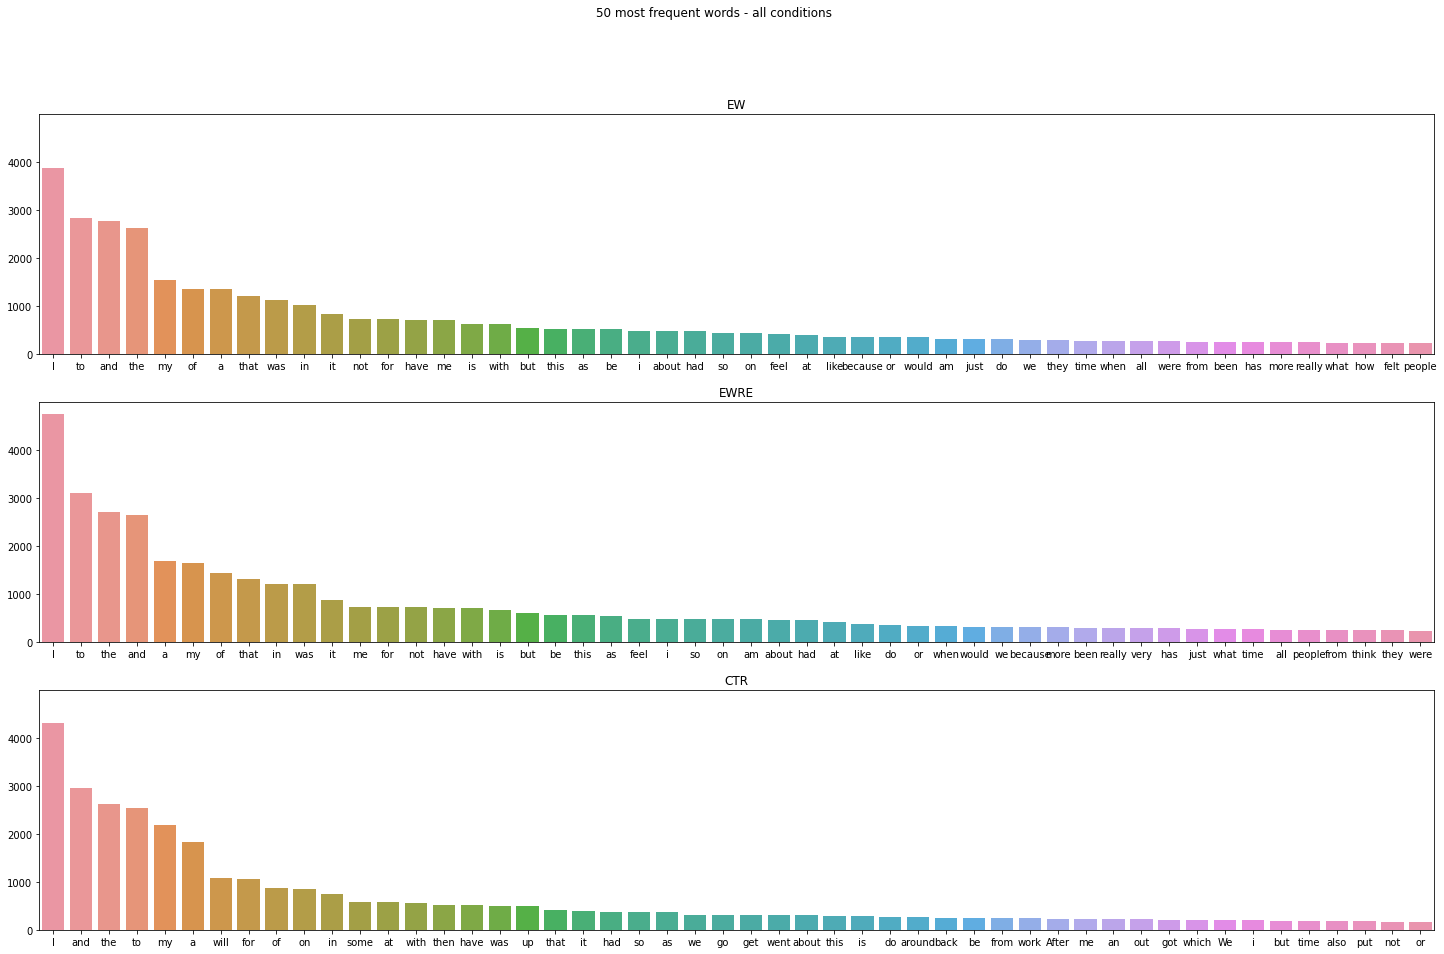

In [155]:
ew_words = writing_df.loc[writing_df.Group == 'EW','writing'].str.split(expand=True).unstack().value_counts()
ewre_words = writing_df.loc[writing_df.Group == 'EWRE','writing'].str.split(expand=True).unstack().value_counts()
ctr_words = writing_df.loc[writing_df.Group == 'CTR', 'writing'].str.split(expand = True).unstack().value_counts()

fig, axes = plt.subplots(3, 1, figsize=(25,15), sharey=True)
fig.suptitle('50 most frequent words - all conditions')

# EW
sns.barplot(ax=axes[0], x=ew_words.index[:50], y=ew_words[:50])
axes[0].set_title('EW')

# EWRE
sns.barplot(ax=axes[1], x=ewre_words.index[:50], y=ewre_words[:50])
axes[1].set_title('EWRE')

# CTR
sns.barplot(ax=axes[2], x=ctr_words.index[:50], y=ctr_words[:50])
axes[2].set_title('CTR')

Even without having done any preprocessing, we can tell there is a difference between the active and control conditions. The word 'feel' makes the top 50 for both EW and EW+RE, but not for CTR, as does the word 'because'. 'Not' is also near the top of the list in both EW and EW+RE, whilst being last on the list of top 50 words in CTR. We will now do some preprocessing and then have another look.

Preprocessing

In [134]:

from nltk.stem.porter import PorterStemmer
import re
import nltk
from nltk.tokenize import word_tokenize
import pkg_resources
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from symspellpy import SymSpell, Verbosity

sym_spell = SymSpell(max_dictionary_edit_distance=3, prefix_length=7)
dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt")
if sym_spell.word_count:
    pass
else:
    sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)

# normalization
def func_norm(s):
    """
    Some basic normalisation.
    in: input string
    out: normalised string.
    
    """
    s = s.lower() # lower case
    # letter repetition (>2)
    s  = re.sub(r'([a-z])\1{2,}', r'\1', s)
    # non word repetition
    s = s = re.sub(r'([\W+])\1{1,}', r'\1', s)
    # noise text
    s = re.sub(r' ing ', ' ', s)
    # phrase repetition
    s = re.sub(r'(.{2,}?)\1{1,}', r'\1', s)

    return s.strip()

def func_punc(w_list):
    """
    in: word list (w_list) to be processed
    out: w_list with punctuation and number filter out
    """
    return [word for word in w_list if word.isalpha()]

def func_stopf(w_list):
    """
    filter stop words
    in:  word list
    out: word list w/o stop words
    """
    stop_words = set(stopwords.words('english'))
    w_list  = [f for f in w_list if f not in stop_words]
    return w_list

# stemming
pstem = PorterStemmer()

def func_stem(w_list):
    """
    stem word list
    in: word list for stemming
    out: stemmed word list 
    """
    sw_list = [pstem.stem(w) for w in w_list]
    return sw_list

# selecting nouns
def func_noun(w_list):
    """
    in: word list to be processed
    out: w_list with only nouns selected
    """
    return [word for (word, pos) in nltk.pos_tag(w_list) if pos[:2] == 'NN']

# spell checker/typo correction
def func_spell(w_list):
    """
    in: word list to be processed
    out: w_list with typo fixed by symspell. words with no match up will be dropped
    """
    w_list_fixed = []
    for word in w_list:
        suggestions = sym_spell.lookup(word, Verbosity.CLOSEST, max_edit_distance=3)
        if suggestions:
            w_list_fixed.append(suggestions[0].term)
        else:
            pass
    return w_list_fixed

def preprocess_sent(rw):
    """
    Get sentence level preprocessed data from raw texts
    in: text to be processed
    out: sentence level pre-processed text
    """
    s = func_norm(rw)

    return s



def preprocess_word(s):
    """
    Get word level preprocessed data from preprocessed sentences
    (remove punctuation, select noun, fix typo, stem, stop_words)
    in: sentence to be processed
    out: word level pre-processed review
    """
    if not s:
        return None
    w_list = word_tokenize(s)
    w_list = func_punc(w_list)
    w_list = func_noun(w_list)
    w_list = func_spell(w_list)
    w_list = func_stem(w_list)
    w_list = func_stopf(w_list)

    return w_list

def preprocess(docs):
    """
    Preprocess the data
    """
    print('Preprocessing raw texts ...')
    #n_docs = len(docs)
    sentences = []  # sentence level preprocessed
    token_lists = []  # word level preprocessed
    #samp = np.random.choice(n_docs)
    for i in range(0, len(docs)):
        sentence = preprocess_sent(docs.iloc[i])
        token_list = preprocess_word(sentence)
        if token_list:
            sentences.append(sentence)
            token_lists.append(token_list)
        print('{} %'.format(str(np.round((i + 1) / len(writing_df.writing) * 100, 2))), end='\r')
    print('Preprocessing raw texts. Done!')
    return sentences, token_lists

In [135]:
sentences, token_lists = preprocess(writing_df.writing)

Preprocessing raw texts ...
Preprocessing raw texts. Done!


We now draw up the same plot as before, but this time we look at the list of words for each group, from all days of writing.

In [206]:
writing_df = writing_df.reset_index(drop = False)
ew_inds = writing_df[writing_df.Group=='EW'].index
ewre_inds = writing_df[writing_df.Group == 'EWRE'].index
ctr_inds = writing_df[writing_df.Group =='CTR'].index
ew_flattened = [item for sublist in token_lists[ew_inds[0]:ew_inds[len(ew_inds)-1]] for item in sublist]
ewre_flattened = [item for sublist in token_lists[ewre_inds[0]:ewre_inds[len(ewre_inds)-1]] for item in sublist]
ctr_flattened = [item for sublist in token_lists[ctr_inds[0]:ctr_inds[len(ctr_inds)-1]] for item in sublist]

Text(0.5, 1.0, 'CTR')

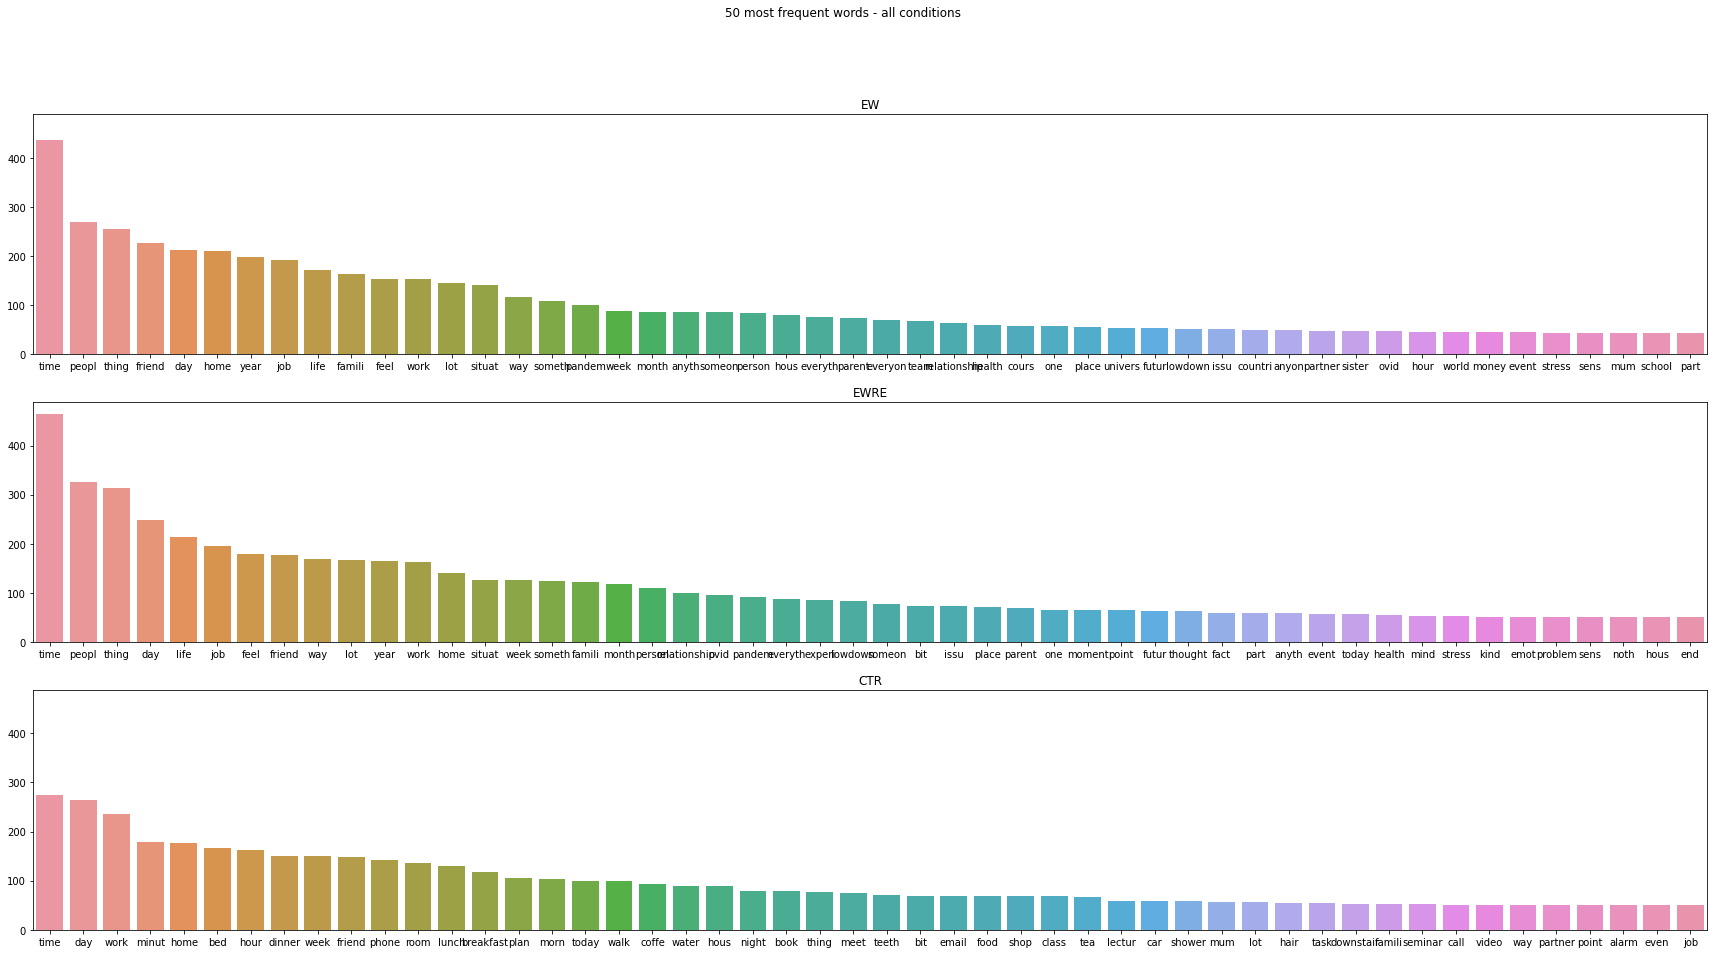

In [248]:
fig, axes = plt.subplots(3, 1, figsize=(30,15), sharey=True)
fig.suptitle('50 most frequent words - all conditions')

# EW
sns.barplot(ax=axes[0], x=pd.Series(ew_flattened).value_counts().index[:50], y=pd.Series(ew_flattened).value_counts()[:50])
axes[0].set_title('EW')

# EWRE
sns.barplot(ax=axes[1], x=pd.Series(ewre_flattened).value_counts().index[:50], y=pd.Series(ewre_flattened).value_counts()[:50])
axes[1].set_title('EWRE')

# CTR
sns.barplot(ax=axes[2], x=pd.Series(ctr_flattened).value_counts().index[:50], y=pd.Series(ctr_flattened).value_counts()[:50])
axes[2].set_title('CTR')

As we can see, the plot has changed quite a bit, and we have a more informative mix of words, rather than just a lot of stop words.

We'll now check how similar the different writing conditions are in terms of the words used. To do this, we calculate the cosine similarity.

In [251]:
def counter_cosine_similarity(c1, c2):
    terms = set(c1).union(c2)
    dotprod = sum(c1.get(k, 0) * c2.get(k, 0) for k in terms)
    magA = math.sqrt(sum(c1.get(k, 0)**2 for k in terms))
    magB = math.sqrt(sum(c2.get(k, 0)**2 for k in terms))
    return dotprod / (magA * magB)

# source: https://stackoverflow.com/questions/14720324/compute-the-similarity-between-two-lists

In [256]:
# calculate cosine similarity between control and each active writing group/between the two active groups


ew_ctr = counter_cosine_similarity(Counter(ew_flattened), Counter(ctr_flattened))
ewre_ctr = counter_cosine_similarity(Counter(ewre_flattened), Counter(ctr_flattened))
ew_ewre = counter_cosine_similarity(Counter(ew_flattened), Counter(ewre_flattened))

print('The similarity between EW and CTR is: ', ew_ctr)
print('The similarity between EWRE and CTR is: ', ewre_ctr)
print('The similarity between EW and EWRE is: ', ew_ewre)

The similarity between EW and CTR is:  0.5939585069939971
The similarity between EWRE and CTR is:  0.5797613032216895
The similarity between EW and EWRE is:  0.9597201461034922


In [257]:
from sklearn.cluster import KMeans
from gensim.corpora.dictionary import Dictionary
from gensim import corpora
import gensim



# define model object
class Topic_Model:
    def __init__(self, k=10, method='TFIDF'):
        """
        :param k: number of topics
        :param method: method chosen for the topic model
        """
        if method not in {'TFIDF', 'LDA', 'BERT'}:
            raise Exception('Invalid method!')
        self.k = k
        self.dictionary = None
        self.corpus = None
        self.cluster_model = None
        self.tfidfmodel = None
        self.ldamodel = None
        self.vec = {}
        self.method = method
        self.AE = None
        self.id = method + '_' + datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")

    def get_vector(self,sentences,token_lists,method = None):
        """
        In: list of tokenized text
        returns: dictionary & corpus
        """ 
        self.dictionary = Dictionary(token_lists)
        print('done')
        self.corpus = [self.dictionary.doc2bow(text) for text in token_lists]
        if not method:
            method = 'TFIDF'
            print("Using default method (TFIDF)", method)
        elif method not in ['TFIDF','LDA']:
            raise Exception('Invalid method!')
        if method == 'TFIDF':
            model = models.TfidfModel(self.corpus)  # fit model
            vec = [model[text] for text in self.corpus]
            return vec
        elif method == 'LDA':
            print('Getting vector representations for LDA ...')
            if not self.ldamodel:
                self.ldamodel = gensim.models.ldamodel.LdaModel(self.corpus, num_topics=self.k, id2word=self.dictionary,
                                                                passes=20)

            def get_vec_lda(model, corpus, k):
                """
                get the LDA vector representation (probabilistic topic assignments for all documents)
                :return: vec_lda with dimension: (n_doc * n_topic)
                """
                n_doc = len(corpus)
                vec_lda = np.zeros((n_doc, k))
                for i in range(n_doc):
                 # get the distribution for the i-th document in corpus
                    for topic, prob in model.get_document_topics(corpus[i]):
                        vec_lda[i, topic] = prob
                return vec_lda

            vec = get_vec_lda(self.ldamodel, self.corpus, self.k)
            print('Getting vector representations for LDA. Done!')
            return vec

        elif method == 'BERT':

            print('Getting vector representations for BERT ...')
            from sentence_transformers import SentenceTransformer
            model = SentenceTransformer('bert-base-nli-max-tokens')
            vec = np.array(model.encode(sentences, show_progress_bar=True))
            print('Getting vector representations for BERT. Done!')
            return vec

    
    def fit(self, sentences, token_lists, method=None, m_clustering=None):
        print(method)    
        if method is None:
            method = self.method
        # Default clustering method
        if m_clustering is None:
            m_clustering = KMeans
        
        if not self.dictionary:
            self.dictionary = Dictionary(token_lists)
            self.corpus = [self.dictionary.doc2bow(text) for text in token_lists]

        if method == 'LDA':
            if not self.ldamodel:
                print('Fitting LDA ...')
                self.ldamodel = gensim.models.ldamodel.LdaModel(self.corpus, num_topics=self.k, id2word=self.dictionary,
                                                                passes=20)
                print('Fitting LDA Done!')
        if method == 'TFIDF':
            self.vec = self.get_vector(sentences,token_lists,method)
            print(self.vec)
            
        else:
            print('Clustering embeddings ...')
            self.cluster_model = m_clustering(self.k)
            self.vec[method] = self.get_vector(sentences, token_lists, method)
            self.cluster_model.fit(self.vec[method])
            print('Clustering embeddings. Done!')

    




In [258]:
def main():
    ntopic = 10
    method = 'TFIDF'
    #parser = argparse.ArgumentParser(description='contextual_topic_identification tm_test:1.0')

    #parser.add_argument('--fpath', default='/kaggle/working/train.csv')
    #parser.add_argument('--ntopic', default=10,)
    #parser.add_argument('--method', default='TFIDF')
    #parser.add_argument('--samp_size', default=20500)
    
    #args = parser.parse_args()

    #data = writing_df.writing 

    #sentences, token_lists, idx_in = preprocess(data)

    tm = Topic_Model(k = ntopic, method = method)
    tm.fit(sentences,token_lists)

        

In [ ]:
main()